## 7. Deep Learning with Keras
conda env:p37env

### Env checks
conda activate p37env  

conda list findstr "tensorflow pandas numpy jupyter sklearn"

In [3]:
# Change the Directory
import os
os.chdir("C:\\Users\\datam\\OneDrive\\Desktop\\python") # change as needed

# Verify the change
os.getcwd()

'C:\\Users\\datam\\OneDrive\\Desktop\\python'

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras import layers, regularizers
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score

In [20]:
# Load the Ames dataset
# You might need to adjust the path depending on your file location
ames = pd.read_csv("ames.csv")

### Dataset Cleanup as in Notebook 2. Regression

In [21]:
# Feature engineering
ames = ames.drop(columns=['Id'])
ames['yearsOld'] = 2011 - ames['YearBuilt']
ames['yearsRemodel'] = 2011 - ames['YearRemodAdd']
ames['yearsGarage'] = 2011 - ames['GarageYrBlt']
ames.loc[:, 'yearsGarage_isNA'] = np.where(ames['yearsGarage'].isna(), 1, 0)
ames.loc[:, 'yearsGarage'] = ames['yearsGarage'].fillna(0)
ames['MoSold'] = ames['MoSold'].astype(str)
ames = ames.drop(columns=ames.columns[[18, 19, 58]])  # Adjusted for 0-based indexing
ames.shape

(1460, 81)

In [22]:
# Handle missing values for select features
ames.loc[:, 'LotFrontage_isNA'] = np.where(ames['LotFrontage'].isna(), 1, 0)
ames.loc[:, 'LotFrontage'] = ames['LotFrontage'].fillna(0)
ames.loc[:, 'MasVnrArea_isNA'] = np.where(ames['MasVnrArea'].isna(), 1, 0)
ames.loc[:, 'MasVnrArea'] = ames['MasVnrArea'].fillna(0)

### Preprocessing - Need further feature reduction

In [25]:
X = ames.drop('SalePrice', axis=1)
y = ames['SalePrice']

In [26]:
# Handle missing values
# Fill with the mean - Try other methods e.g. median
X = X.fillna(X.mean(numeric_only=True))  # Fill numeric columns with mean
y = y.fillna(y.mean())  # Fill target with mean (if any missing)

In [27]:
# Convert categorical variables to numeric
X = pd.get_dummies(X)
X.shape

(1460, 301)

In [29]:
X.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,65.0,8450,7,5,196.0,706,0,150,856,...,False,False,False,True,False,False,False,False,True,False
1,20,80.0,9600,6,8,0.0,978,0,284,1262,...,False,False,False,True,False,False,False,False,True,False
2,60,68.0,11250,7,5,162.0,486,0,434,920,...,False,False,False,True,False,False,False,False,True,False
3,70,60.0,9550,7,5,0.0,216,0,540,756,...,False,False,False,True,True,False,False,False,False,False
4,60,84.0,14260,8,5,350.0,655,0,490,1145,...,False,False,False,True,False,False,False,False,True,False


In [37]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1942)

In [38]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Log-transform target (since SalePrice is skewed) and scale
y_train_log = np.log1p(y_train)  # log1p handles zeros gracefully
y_test_log = np.log1p(y_test)
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train_log.values.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test_log.values.reshape(-1, 1)).flatten()

In [39]:
# Define the model
# Note that relu activation is...
# kernel regularizers...
# batch normalization...
# dropout...
# optimizer Adam vs...

# Model
def build_model(input_dim):
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(128, kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.3),
        layers.Dense(64, kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.3),
        layers.Dense(32),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.2),
        layers.Dense(1)
    ])
    optimizer = keras.optimizers.Adam(learning_rate=0.001)  # Switch to Adam
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

# Train
model = build_model(X_train_scaled.shape[1])
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
history = model.fit(
    X_train_scaled, y_train_scaled, epochs=200, batch_size=32, 
    validation_split=0.2, callbacks=[early_stopping], verbose=1
)

Epoch 1/200
26/26 [==============================] - 2s 16ms/step - loss: 1.2671 - mae: 0.7676 - val_loss: 0.9402 - val_mae: 0.6329
Epoch 2/200
26/26 [==============================] - 0s 5ms/step - loss: 0.8556 - mae: 0.5898 - val_loss: 0.5857 - val_mae: 0.4306
Epoch 3/200
26/26 [==============================] - 0s 5ms/step - loss: 0.7881 - mae: 0.5556 - val_loss: 0.5129 - val_mae: 0.3708
Epoch 4/200
26/26 [==============================] - 0s 5ms/step - loss: 0.6972 - mae: 0.5146 - val_loss: 0.4629 - val_mae: 0.3273
Epoch 5/200
26/26 [==============================] - 0s 4ms/step - loss: 0.6639 - mae: 0.4875 - val_loss: 0.4390 - val_mae: 0.3030
Epoch 6/200
26/26 [==============================] - 0s 4ms/step - loss: 0.6184 - mae: 0.4695 - val_loss: 0.4217 - val_mae: 0.2872
Epoch 7/200
26/26 [==============================] - 0s 4ms/step - loss: 0.6007 - mae: 0.4525 - val_loss: 0.4325 - val_mae: 0.2893
Epoch 8/200
26/26 [==============================] - 0s 4ms/step - loss: 0.5931 - 

In [40]:
# Predict and unscale
test_predictions_scaled = model.predict(X_test_scaled).flatten()
test_predictions_log = scaler_y.inverse_transform(test_predictions_scaled.reshape(-1, 1)).flatten()
test_predictions = np.expm1(test_predictions_log)  # Reverse log1p
y_test_unscaled = np.expm1(y_test_scaled)  # Should match y_test, but let's compute metrics directly

14/14 [==============================] - 0s 2ms/step


In [41]:
# Calculate metrics
mae = mean_absolute_error(y_test, test_predictions)
mape = mean_absolute_percentage_error(y_test, test_predictions)
r2 = r2_score(y_test, test_predictions)

print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}")
print(f"R2 Score: {r2:.2f}")

MAE: 19876.55
MAPE: 0.11
R2 Score: 0.81


In [42]:
# Manual R² check
mse = np.mean((y_test - test_predictions) ** 2)
variance = np.var(y_test)
print(f"MSE: {mse:.2f}, Variance: {variance:.2f}, Manual R²: {1 - mse/variance:.2f}")

MSE: 1213270418.01, Variance: 6454882243.28, Manual R²: 0.81


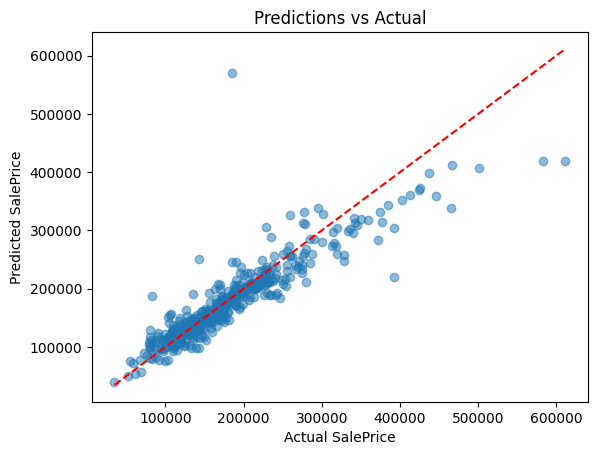

In [43]:
# Plot predictions
plt.scatter(y_test, test_predictions, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual SalePrice')
plt.ylabel('Predicted SalePrice')
plt.title('Predictions vs Actual')
plt.show()

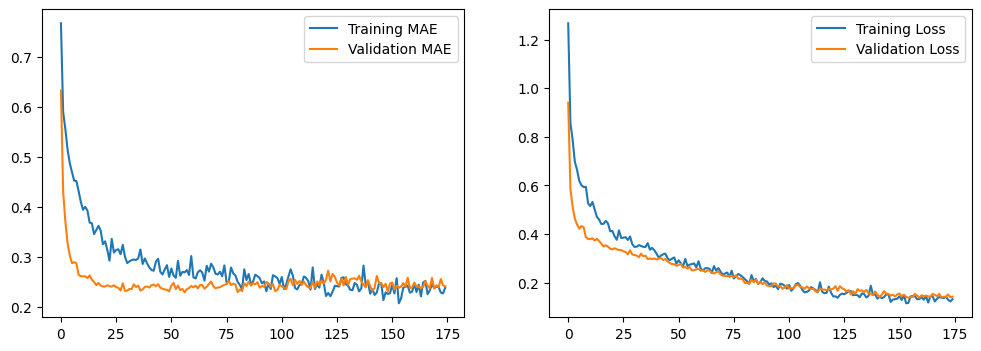

In [44]:
# Plot history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

In [45]:
# Permutation Importance (simplified version)
#def permutation_importance(model, X_test, y_test, feature_names, scaler_y, n_repeats=3):
#    baseline_pred = model.predict(X_test).flatten()
#    baseline_pred_unscaled = scaler_y.inverse_transform(baseline_pred.reshape(-1, 1)).flatten()
#    baseline_mae = mean_absolute_error(y_test, baseline_pred_unscaled)
#    importances = []
    
#    for col_idx in range(X_test.shape[1]):
#        X_permuted = X_test.copy()
#        np.random.shuffle(X_permuted[:, col_idx])
#        permuted_pred = model.predict(X_permuted, verbose=0).flatten()
#        permuted_pred_unscaled = scaler_y.inverse_transform(permuted_pred.reshape(-1, 1)).flatten()
#        permuted_mae = mean_absolute_error(y_test, permuted_pred_unscaled)
#        importances.append(permuted_mae - baseline_mae)
    
#    return np.array(importances)

In [50]:
# --- Fixed Permutation Importance ---
def permutation_importance(model, X_test_scaled, y_test, feature_names, scaler_y, n_repeats=3):
    # Baseline prediction in original scale
    baseline_pred_scaled = model.predict(X_test_scaled).flatten()
    baseline_pred_log = scaler_y.inverse_transform(baseline_pred_scaled.reshape(-1, 1)).flatten()
    baseline_pred = np.expm1(baseline_pred_log)
    baseline_mae = mean_absolute_error(y_test, baseline_pred)
    
    importances = []
    for col_idx in range(X_test_scaled.shape[1]):
        print(f"Processing feature {col_idx + 1}/{X_test_scaled.shape[1]}")
        col_importance = []
        for _ in range(n_repeats):
            X_permuted = X_test_scaled.copy()
            np.random.shuffle(X_permuted[:, col_idx])
            permuted_pred_scaled = model.predict(X_permuted, verbose=0).flatten()
            permuted_pred_log = scaler_y.inverse_transform(permuted_pred_scaled.reshape(-1, 1)).flatten()
            permuted_pred = np.expm1(permuted_pred_log)
            permuted_mae = mean_absolute_error(y_test, permuted_pred)
            col_importance.append(permuted_mae - baseline_mae)
        importances.append(np.mean(col_importance))
    
    return np.array(importances)

In [51]:
# Calculate and display top 10 features
feature_names = X.columns
importances = permutation_importance(model, X_test_scaled, y_test_unscaled, feature_names, scaler_y)
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
top_10 = importance_df.sort_values('Importance', ascending=False).head(10)

print("\nTop 10 Most Important Features:")
print(top_10)

14/14 [==============================] - 0s 2ms/step
Processing feature 1/301
Processing feature 2/301
Processing feature 3/301
Processing feature 4/301
Processing feature 5/301
Processing feature 6/301
Processing feature 7/301
Processing feature 8/301
Processing feature 9/301
Processing feature 10/301
Processing feature 11/301
Processing feature 12/301
Processing feature 13/301
Processing feature 14/301
Processing feature 15/301
Processing feature 16/301
Processing feature 17/301
Processing feature 18/301
Processing feature 19/301
Processing feature 20/301
Processing feature 21/301
Processing feature 22/301
Processing feature 23/301
Processing feature 24/301
Processing feature 25/301
Processing feature 26/301
Processing feature 27/301
Processing feature 28/301
Processing feature 29/301
Processing feature 30/301
Processing feature 31/301
Processing feature 32/301
Processing feature 33/301
Processing feature 34/301
Processing feature 35/301
Processing feature 36/301
Processing feature 3

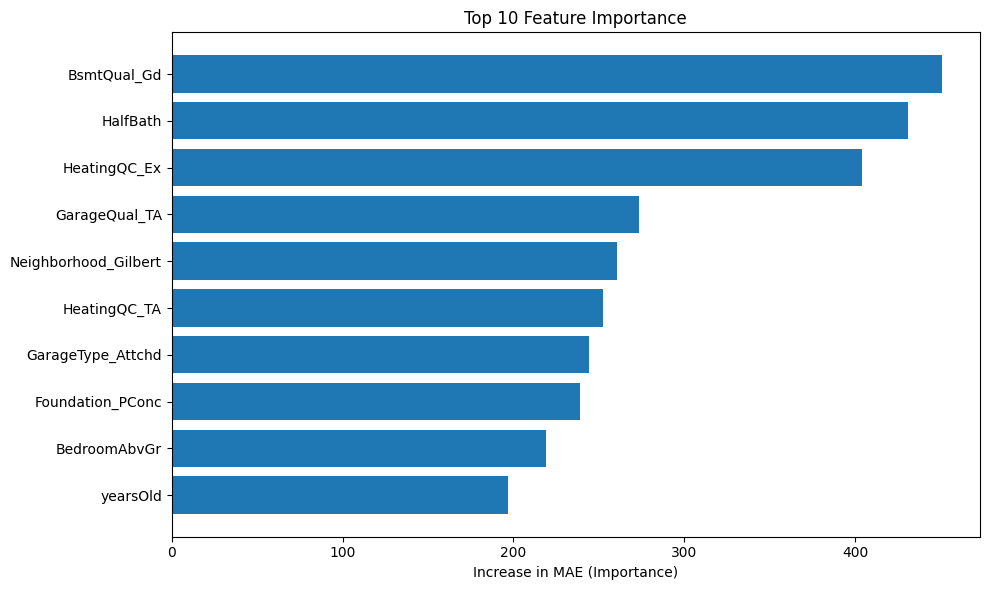

In [52]:
# Visualize top 10 features
plt.figure(figsize=(10, 6))
plt.barh(top_10['Feature'], top_10['Importance'])
plt.xlabel('Increase in MAE (Importance)')
plt.title('Top 10 Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()